Loading models...
Models loaded successfully!

Loading test CSV...
   vibration  temperature   pressure     torque   current          rpm
0   0.093040    54.936864  28.185761  48.293108  9.580219  1480.477201
1   0.018762    55.278095  27.922274  47.845922  9.373899  1480.551067
2   0.043032    55.523141  27.347877  48.062283  9.472697  1481.093914
3   0.046843    55.550285  27.787572  48.041249  9.384407  1479.869384
4   0.092413    54.878313  28.005214  48.055280  9.552750  1483.391766
Shape: (1000, 6)

Scaling data...
Scaling complete!

Creating windows...
Windowed shape: (900, 100, 6)

Running autoencoder...
Anomaly score example: [2.80336562 2.80357117 2.80309669 2.80265892 2.80153366]

Predicting RUL...
RUL example: [1255.0084 1257.3015 1258.394  1256.4441 1256.6831]

Predicting failure probability...
Failure prob example: [1. 1. 1. 1. 1.]

Computing Health Index...
Health index example: [0.43154299 0.43118356 0.43233574 0.43324937 0.43586304]

Generating plots...


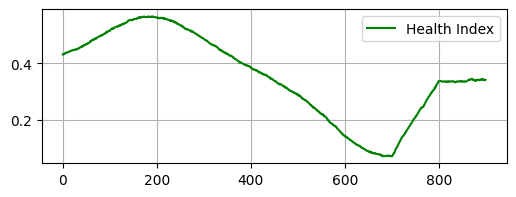

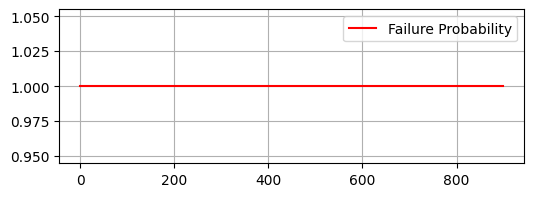

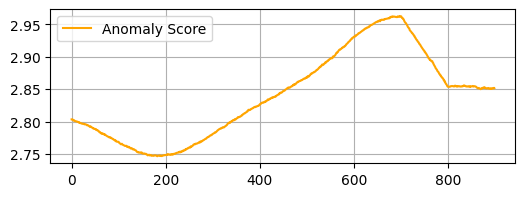

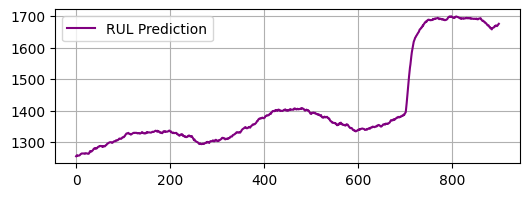


Plots generated successfully!

================ FINAL OUTPUT ================
Final Health Index: 0.341
Final Failure Probability: 1.0
Final Predicted RUL: 1675.43 steps



In [5]:
# ============================================================
# 1. IMPORTS
# ============================================================
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# ============================================================
# 2. LOAD MODELS
# ============================================================
print("Loading models...")

autoencoder = tf.keras.models.load_model("../models/autoencoder_model")
lstm_rul = tf.keras.models.load_model("../models/lstm_rul_model")

with open("../models/fusion_model.pkl", "rb") as f:
    fusion_model = pickle.load(f)

with open("../models/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

print("Models loaded successfully!")

# ============================================================
# 3. LOAD TEST CSV
# ============================================================
print("\nLoading test CSV...")

df = pd.read_csv("hybrid_small_test_dataset.csv")  # <--------------------------------------   place your test CSV here
print(df.head())
print("Shape:", df.shape)

required_cols = ["vibration","temperature","pressure","torque","current","rpm"]
X_raw = df[required_cols].values

# ============================================================
# 4. SCALING
# ============================================================
print("\nScaling data...")
X_scaled = scaler.transform(X_raw)
print("Scaling complete!")

# ============================================================
# 5. WINDOWING FUNCTION
# ============================================================
def create_windows(data, window=100):
    X = []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
    return np.array(X)

print("\nCreating windows...")
X_input = create_windows(X_scaled)
print("Windowed shape:", X_input.shape)

# ============================================================
# 6. AUTOENCODER ANOMALY SCORE
# ============================================================
print("\nRunning autoencoder...")
X_rec = autoencoder.predict(X_input, verbose=0)
anomaly_scores = np.mean((X_input - X_rec)**2, axis=(1,2))
print("Anomaly score example:", anomaly_scores[:5])

# ============================================================
# 7. LSTM RUL PREDICTION
# ============================================================
print("\nPredicting RUL...")
rul_scaled = lstm_rul.predict(X_input, verbose=0).flatten()
rul_pred = rul_scaled * 9900
print("RUL example:", rul_pred[:5])

# ============================================================
# 8. FAILURE PROBABILITY (FUSION MODEL)
# ============================================================
print("\nPredicting failure probability...")
fusion_features = np.column_stack([anomaly_scores, rul_pred])
failure_prob = fusion_model.predict_proba(fusion_features)[:,1]
print("Failure prob example:", failure_prob[:5])

# ============================================================
# 9. HEALTH INDEX
# ============================================================
print("\nComputing Health Index...")
anomaly_norm = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
health_index = 0.5 * (1 - anomaly_norm) + 0.5 * rul_scaled
print("Health index example:", health_index[:5])

# ============================================================
# 10. PLOTS
# ============================================================
print("\nGenerating plots...")

plt.figure(figsize=(6,2))
plt.plot(health_index, label="Health Index", color="green")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,2))
plt.plot(failure_prob, label="Failure Probability", color="red")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,2))
plt.plot(anomaly_scores, label="Anomaly Score", color="orange")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,2))
plt.plot(rul_pred, label="RUL Prediction", color="purple")
plt.legend(); plt.grid(); plt.show()

print("\nPlots generated successfully!")

# ============================================================
# 11. FINAL OUTPUT
# ============================================================
print("\n================ FINAL OUTPUT ================")
print("Final Health Index:", round(float(health_index[-1]), 3))
print("Final Failure Probability:", round(float(failure_prob[-1]), 3))
print("Final Predicted RUL:", round(float(rul_pred[-1]), 2), "steps")
print("=============================================\n")
